## IBM  DATA SCIENCE COURSERA  CAPSTONE



### Toronto Neighborhood Analysis
The outline of this script is;

1. Installing and Impoting Data Libraries
2. Import/read fines from websites
3. Cleans the data
4. Explore and Map the neighborhoods in Toronto
5. Defining Foursquare 
6. Analyze Each Neighborhood
7. Cluster Neighbourhoods
8. Results/and findings
9. Colclusion


### 1.  Installing and Impoting Data Libraries


In [59]:
#Geopy library for handling geo-spatial data
#pip install geopy
#Folium for map plotting based on lat and lng
#pip install folium=0.5.0

In [60]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe

import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import json # to process json files

# Import plotting libraries
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

# Set plot style
print(plt.style.available)
mpl.style.use(['ggplot']) # optional: for ggplot-like style



['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


###  2. Reading/scraping  data from sites

#### 2.1 Toronto  Neighborhood data from wikipida
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [61]:
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(source, 'lxml')

table = soup.find("table")
table_rows = table.tbody.find_all("tr")

res = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    
    # Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
    if row != [] and row[1] != "Not assigned\n":
        # If a cell has a borough but a "Not assigned" neighborhood, then the neighborhood will be the same as the borough.
        if "Not assigned\n" in row[2]: 
            row[2] = row[1]
        res.append(row)

# Dataframe with 3 columns
toronto_data = pd.DataFrame(res, columns = ["PostalCode", "Borough", "Neighbourhood"])

# Remove "\n" at the end of each string in the columns
toronto_data["PostalCode"] = toronto_data["PostalCode"].str.replace("\n","")
toronto_data["Borough"] = toronto_data["Borough"].str.replace("\n","")
toronto_data["Neighbourhood"] = toronto_data["Neighbourhood"].str.replace("\n","")

toronto_data.head()

,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [62]:
# toronto_data.shape

####  2.2 Geo data 
####  Using “https://cocl.us/Geospatial_data” csv file to get all the geographical coordinates of the neighborhoods.

In [63]:
## Get the coordinates of the data 

geo_data = pd.read_csv("https://cocl.us/Geospatial_data")

geo_data.head()
#print(geo_data.shape)

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### 3.  Data Cleaning/grouping

In [64]:
## Group all neighborhoods with the same postal code

toronto_data = toronto_data.groupby(["PostalCode", "Borough"])["Neighbourhood"].apply(", ".join).reset_index()
toronto_data.head()

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


####  4. Combining the  main data and geo_data

In [65]:
#We need to couple 2 dataframes "df" and "df_geo_coor" into one dataframe.


df_toronto = pd.merge(toronto_data, geo_data, how='left', left_on = 'PostalCode', right_on = 'Postal Code')
# remove the "Postal Code" column
df_toronto.drop("Postal Code", axis=1, inplace=True)
df_toronto.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [66]:
print ("Shape: ", df_toronto.shape)

Shape:  (103, 5)


###  4. Explore and Map the neighborhoods in Toronto

#### 4.1. Get the latitude and longitude values of Toronto.

In [67]:
# Mapping the torinto are and add the locaiaons

# get Toronto cooridntase
address = "Toronto, ON"

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

 #### 4.2. Create a map of the whole Toronto City with neighborhoods superimposed on top

In [68]:
# Mapping the torinto are and add the locaiaons

# create map of Manhattan using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### 5 Defining Foursquare 

#### 5.1. Define Foursquare Credentials and Version

In [69]:
CLIENT_ID = 'XXXXXXXXXXXXXXXX' # hiding for secutity , you can add your oun credentials
CLIENT_SECRET= 'XXXXXXXXXXXXX' # hiding for secutity , you can add your oun credentials
VERSION = 20202612
radius = 500
LIMIT = 100

In [70]:
# Write a python function

#Part 1 creating the API request  URl

def getNearbyVenues (names, latitudes, longitudes):
    venues_list =[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        
#part 2: making the Request

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
    
#part 3 returning only relevenat  information for each nearby venueand append to the list
   
        venues_list.append ([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],   
            v['venue']['categories'][0]['name']) for v in results])

    return (venues_list)  
    

#### 5.2 Analysis/Preview of Data

In [71]:
antwerp_venues = getNearbyVenues (names = df_toronto['Neighbourhood'],                                  
                                 latitudes = df_toronto['Latitude'],
                                 longitudes = df_toronto['Longitude'])

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [72]:
antwerp_venues

[[('Malvern, Rouge',
   43.806686299999996,
   -79.19435340000001,
   'Wendy’s',
   43.80744841934756,
   -79.19905558052072,
   'Fast Food Restaurant')],
 [('Rouge Hill, Port Union, Highland Creek',
   43.7845351,
   -79.16049709999999,
   'Royal Canadian Legion',
   43.78253332838298,
   -79.16308473261682,
   'Bar')],
 [('Guildwood, Morningside, West Hill',
   43.7635726,
   -79.1887115,
   'RBC Royal Bank',
   43.76678992471017,
   -79.19115118872593,
   'Bank'),
  ('Guildwood, Morningside, West Hill',
   43.7635726,
   -79.1887115,
   'G & G Electronics',
   43.765309,
   -79.191537,
   'Electronics Store'),
  ('Guildwood, Morningside, West Hill',
   43.7635726,
   -79.1887115,
   'Sail Sushi',
   43.765951,
   -79.191275,
   'Restaurant'),
  ('Guildwood, Morningside, West Hill',
   43.7635726,
   -79.1887115,
   'Big Bite Burrito',
   43.766299084470795,
   -79.19071980583941,
   'Mexican Restaurant'),
  ('Guildwood, Morningside, West Hill',
   43.7635726,
   -79.1887115,
   'Ent

In [73]:
# Extract Totonto near by 

Totonto_nearby_v= pd.DataFrame([item for venue_list in antwerp_venues for item in venue_list])

# Rename colnmens

Totonto_nearby_v.columns = ['Neighbourhood',
                         'Neighbourhood Latitude',
                        'Neighbourhood Longitude',
                        'Venuse',
                        'Venue Latitude',
                        'Venue Longitude',
                        'Venue Category']

In [74]:
Totonto_nearby_v

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venuse,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Sail Sushi,43.765951,-79.191275,Restaurant
...,...,...,...,...,...,...,...
2124,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,Pizza Nova,43.736761,-79.589817,Pizza Place
2125,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,Rogers Plus,43.741312,-79.585263,Video Store
2126,"Northwest, West Humber - Clairville",43.706748,-79.594054,Economy Rent A Car,43.708471,-79.589943,Rental Car Location
2127,"Northwest, West Humber - Clairville",43.706748,-79.594054,Saand Rexdale,43.705072,-79.598725,Drugstore


In [75]:
# Find the unique  number of categories in tornot

print('There are {} uniques categories.'.format(len(Totonto_nearby_v['Venue Category'].unique())))

df_count =Totonto_nearby_v.groupby('Neighbourhood').count()

There are 273 uniques categories.


In [76]:
df_count
df_count_Soreted = df_count.sort_values(['Venue Category'], ascending = (True))
Top10Neighborhoods = df_count_Soreted.tail(10)
Bottom10Neghborhoods =  df_count_Soreted.head(10)

In [77]:
Top10Neighborhoods

,Neighbourhood Latitude,Neighbourhood Longitude,Venuse,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Fairview, Henry Farm, Oriole",66,66,66,66,66,66
Church and Wellesley,77,77,77,77,77,77
St. James Town,78,78,78,78,78,78
"Richmond, Adelaide, King",97,97,97,97,97,97
Stn A PO Boxes,98,98,98,98,98,98
"First Canadian Place, Underground city",100,100,100,100,100,100
"Garden District, Ryerson",100,100,100,100,100,100
"Harbourfront East, Union Station, Toronto Islands",100,100,100,100,100,100
"Toronto Dominion Centre, Design Exchange",100,100,100,100,100,100


In [78]:
Bottom10Neghborhoods

,Neighbourhood Latitude,Neighbourhood Longitude,Venuse,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"York Mills, Silver Hills",1,1,1,1,1,1
"Humberlea, Emery",1,1,1,1,1,1
"Malvern, Rouge",1,1,1,1,1,1
"Rouge Hill, Port Union, Highland Creek",1,1,1,1,1,1
"West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale",1,1,1,1,1,1
Humber Summit,1,1,1,1,1,1
Scarborough Village,2,2,2,2,2,2
Roselawn,2,2,2,2,2,2
York Mills West,2,2,2,2,2,2


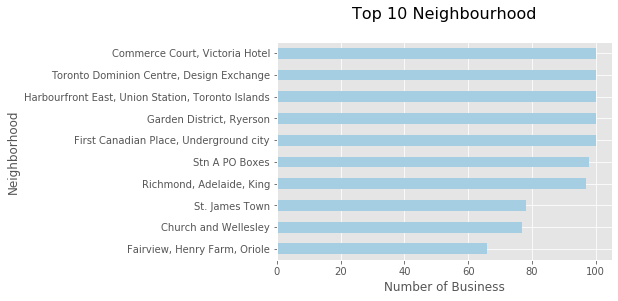

In [79]:
Top10Neighborhoods[['Venue Category']].plot(kind='barh',colormap='Paired');

plt.title('Top 10 Neighbourhood\n', size = 16 )
plt.ylabel('Neighborhood')
plt.xlabel('Number of Business')
plt.gca().get_legend().remove() # remove legend

plt.show()

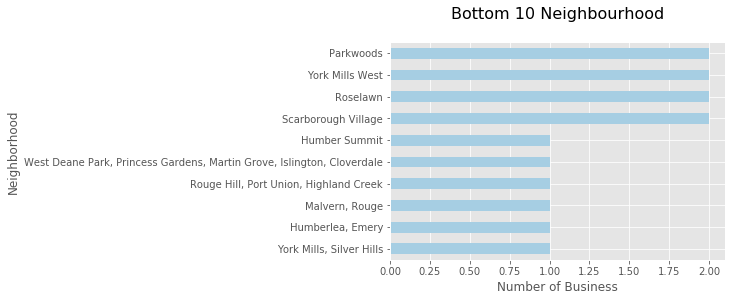

In [80]:

Bottom10Neghborhoods[['Venue Category']].plot(kind='barh',colormap='Paired');

plt.title('Bottom 10 Neighbourhood\n', size = 16 )
plt.ylabel('Neighborhood')
plt.xlabel('Number of Business')
plt.gca().get_legend().remove() # remove legend

plt.show()


###  6. Analyze Each Neighborhood


#### 6.1  Onehot Assignemnt

In [81]:
# one hot encoding
toronto_onehot = pd.get_dummies(Totonto_nearby_v[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = Totonto_nearby_v['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Rouge Hill, Port Union, Highland Creek",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
toronto_onehot.shape

(2129, 274)

In [83]:
#df_count2 =toronto_onehot.groupby('Neighbourhood').count()


####  Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [84]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,York Mills West,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Let's confirm the new size

In [85]:
toronto_grouped.shape

(96, 274)

####  Print each neighborhood along with the top 5 most common venues

In [86]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0             Breakfast Spot   0.2
1               Skating Rink   0.2
2                     Lounge   0.2
3             Clothing Store   0.2
4  Latin American Restaurant   0.2


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.25
1             Pub  0.12
2  Sandwich Place  0.12
3     Coffee Shop  0.12
4             Gym  0.12


----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0                Coffee Shop  0.09
1                       Bank  0.09
2          Health Food Store  0.04
3  Middle Eastern Restaurant  0.04
4           Sushi Restaurant  0.04


----Bayview Village----
                 venue  freq
0                 Bank  0.25
1   Chinese Restaurant  0.25
2  Japanese Restaurant  0.25
3                 Café  0.25
4  Monument / Landmark  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0  Italian Restaurant  0.08
1         Coffee Shop  0.08

                        venue  freq
0  Construction & Landscaping  0.25
1            Basketball Court  0.25
2                        Park  0.25
3                      Bakery  0.25
4  Modern European Restaurant  0.00


----North Toronto West,  Lawrence Park----
                 venue  freq
0  Sporting Goods Shop  0.11
1       Clothing Store  0.11
2          Coffee Shop  0.11
3          Yoga Studio  0.06
4           Restaurant  0.06


----Northwest, West Humber - Clairville----
                 venue  freq
0            Drugstore  0.33
1           Truck Stop  0.33
2  Rental Car Location  0.33
3    Accessories Store  0.00
4        Movie Theater  0.00


----Northwood Park, York University----
                    venue  freq
0  Furniture / Home Store  0.33
1          Massage Studio  0.17
2             Coffee Shop  0.17
3                     Bar  0.17
4    Caribbean Restaurant  0.17


----Old Mill South, King's Mill Park, Sunnylea, Humber Bay, Mimico NE, The Queensway East, Royal York South E

####  put that into a pandas dataframe
#### First, let's write a function to sort the venues in descending order.

In [87]:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

####  Now let's create the new dataframe and display the top 10 venues for each neighborhood

In [88]:
# Getting the first 10 common venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Skating Rink,Lounge,Breakfast Spot,Latin American Restaurant,Clothing Store,Escape Room,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
1,"Alderwood, Long Branch",Pizza Place,Pool,Pub,Coffee Shop,Gym,Pharmacy,Sandwich Place,Escape Room,Electronics Store,Eastern European Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Health Food Store,Supermarket,Bridal Shop,Shopping Mall,Sandwich Place,Restaurant,Pizza Place,Pharmacy
3,Bayview Village,Japanese Restaurant,Bank,Chinese Restaurant,Café,Yoga Studio,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Thai Restaurant,Italian Restaurant,Café,Japanese Restaurant,Sushi Restaurant,Restaurant,Indian Restaurant,Juice Bar


In [89]:
neighbourhoods_venues_sorted.shape

(96, 11)

### 7. Cluster Neighbourhoods¶
#### 7.1 Run k-means to cluster the Toronto into 6 clusters

In [90]:
# this is my k-test from th other script

In [91]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [92]:
# scale the continuous features

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

mms = MinMaxScaler()
mms.fit(toronto_grouped_clustering)
toronto_grouped_clustering_transformed = mms.transform(toronto_grouped_clustering)

In [93]:
#toronto_grouped_clustering

In [94]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped_clustering_transformed)
    Sum_of_squared_distances.append(km.inertia_)

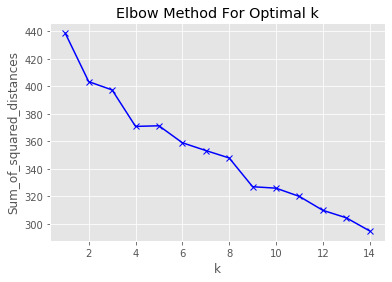

In [95]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [96]:
# set number of clusters
kclusters =7

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [97]:
# add clustering labels

neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

neighbourhoods_venues_sorted.head() # check the last columns!


,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Agincourt,Skating Rink,Lounge,Breakfast Spot,Latin American Restaurant,Clothing Store,Escape Room,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
1,0,"Alderwood, Long Branch",Pizza Place,Pool,Pub,Coffee Shop,Gym,Pharmacy,Sandwich Place,Escape Room,Electronics Store,Eastern European Restaurant
2,0,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Health Food Store,Supermarket,Bridal Shop,Shopping Mall,Sandwich Place,Restaurant,Pizza Place,Pharmacy
3,0,Bayview Village,Japanese Restaurant,Bank,Chinese Restaurant,Café,Yoga Studio,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
4,0,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Thai Restaurant,Italian Restaurant,Café,Japanese Restaurant,Sushi Restaurant,Restaurant,Indian Restaurant,Juice Bar


#### 7.2 Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [98]:
neighbourhoods_venues_sorted.shape

(96, 12)

In [99]:
toronto_merged

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,1.0,Fast Food Restaurant,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,0.0,Bar,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Filipino Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Intersection,Rental Car Location,Medical Center,Electronics Store,Mexican Restaurant,Bank,Restaurant,Breakfast Spot,Cupcake Shop,Curling Ice
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Coffee Shop,Korean BBQ Restaurant,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Gas Station,Bakery,Caribbean Restaurant,Thai Restaurant,Athletics & Sports,Fried Chicken Joint,Bank,Hakka Restaurant,Escape Room,Electronics Store
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188,6.0,Park,Jewelry Store,Convenience Store,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
99,M9P,Etobicoke,Westmount,43.696319,-79.532242,0.0,Pizza Place,Coffee Shop,Middle Eastern Restaurant,Discount Store,Sandwich Place,Chinese Restaurant,Intersection,Creperie,Coworking Space,Event Space
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724,0.0,Sandwich Place,Park,Mobile Phone Shop,Bus Line,Drugstore,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,0.0,Pizza Place,Grocery Store,Video Store,Sandwich Place,Fast Food Restaurant,Beer Store,Fried Chicken Joint,Pharmacy,Golf Course,Department Store


In [100]:
neighbourhoods_venues_sorted

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Agincourt,Skating Rink,Lounge,Breakfast Spot,Latin American Restaurant,Clothing Store,Escape Room,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
1,0,"Alderwood, Long Branch",Pizza Place,Pool,Pub,Coffee Shop,Gym,Pharmacy,Sandwich Place,Escape Room,Electronics Store,Eastern European Restaurant
2,0,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Health Food Store,Supermarket,Bridal Shop,Shopping Mall,Sandwich Place,Restaurant,Pizza Place,Pharmacy
3,0,Bayview Village,Japanese Restaurant,Bank,Chinese Restaurant,Café,Yoga Studio,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
4,0,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Thai Restaurant,Italian Restaurant,Café,Japanese Restaurant,Sushi Restaurant,Restaurant,Indian Restaurant,Juice Bar
...,...,...,...,...,...,...,...,...,...,...,...,...
91,0,"Willowdale, Willowdale West",Pizza Place,Grocery Store,Butcher,Coffee Shop,Pharmacy,Concert Hall,Discount Store,Falafel Restaurant,Event Space,Ethiopian Restaurant
92,0,Woburn,Coffee Shop,Korean BBQ Restaurant,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
93,0,Woodbine Heights,Skating Rink,Curling Ice,Park,Spa,Beer Store,Dance Studio,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
94,6,York Mills West,Park,Convenience Store,Yoga Studio,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant


In [101]:
#tempDF.loc[(tempDF['var2']=='b')

# select all the Custers that have volues zero and more
toronto_merged_Clusters =toronto_merged.loc[(toronto_merged['Cluster Labels']>= 0)]


In [102]:
toronto_merged_Clusters

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,1.0,Fast Food Restaurant,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,0.0,Bar,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Filipino Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Intersection,Rental Car Location,Medical Center,Electronics Store,Mexican Restaurant,Bank,Restaurant,Breakfast Spot,Cupcake Shop,Curling Ice
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Coffee Shop,Korean BBQ Restaurant,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Gas Station,Bakery,Caribbean Restaurant,Thai Restaurant,Athletics & Sports,Fried Chicken Joint,Bank,Hakka Restaurant,Escape Room,Electronics Store
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188,6.0,Park,Jewelry Store,Convenience Store,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
99,M9P,Etobicoke,Westmount,43.696319,-79.532242,0.0,Pizza Place,Coffee Shop,Middle Eastern Restaurant,Discount Store,Sandwich Place,Chinese Restaurant,Intersection,Creperie,Coworking Space,Event Space
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724,0.0,Sandwich Place,Park,Mobile Phone Shop,Bus Line,Drugstore,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,0.0,Pizza Place,Grocery Store,Video Store,Sandwich Place,Fast Food Restaurant,Beer Store,Fried Chicken Joint,Pharmacy,Golf Course,Department Store


In [103]:
toronto_merged_Clusters.dtypes


PostalCode                 object
Borough                    object
Neighbourhood              object
Latitude                  float64
Longitude                 float64
Cluster Labels            float64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

In [104]:
toronto_merged_Clusters['Cluster Labels'] = toronto_merged_Clusters['Cluster Labels'].astype(int)

C:\Users\Belachew\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [105]:
# visualize the resulting clusters
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, nei, cluster in zip(toronto_merged_Clusters['Latitude'], toronto_merged_Clusters['Longitude'],toronto_merged_Clusters['PostalCode'], toronto_merged_Clusters['Neighbourhood'], toronto_merged_Clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster: ' + str(cluster) + ' Neighbourhood(s): ' + str(nei), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [106]:
neighbourhoods_venues_sorted.shape


(96, 12)

In [107]:
#toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0] + list(range(2, toronto_merged.shape[1]))]]

,PostalCode,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,M1C,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,0.0,Bar,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Filipino Restaurant
2,M1E,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Intersection,Rental Car Location,Medical Center,Electronics Store,Mexican Restaurant,Bank,Restaurant,Breakfast Spot,Cupcake Shop,Curling Ice
3,M1G,Woburn,43.770992,-79.216917,0.0,Coffee Shop,Korean BBQ Restaurant,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
4,M1H,Cedarbrae,43.773136,-79.239476,0.0,Gas Station,Bakery,Caribbean Restaurant,Thai Restaurant,Athletics & Sports,Fried Chicken Joint,Bank,Hakka Restaurant,Escape Room,Electronics Store
5,M1J,Scarborough Village,43.744734,-79.239476,0.0,Playground,Jewelry Store,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Field
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,M9C,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",43.643515,-79.577201,0.0,Pizza Place,Beer Store,Pharmacy,Convenience Store,Coffee Shop,Café,Shopping Plaza,Park,Liquor Store,Pet Store
99,M9P,Westmount,43.696319,-79.532242,0.0,Pizza Place,Coffee Shop,Middle Eastern Restaurant,Discount Store,Sandwich Place,Chinese Restaurant,Intersection,Creperie,Coworking Space,Event Space
100,M9R,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724,0.0,Sandwich Place,Park,Mobile Phone Shop,Bus Line,Drugstore,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio
101,M9V,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,0.0,Pizza Place,Grocery Store,Video Store,Sandwich Place,Fast Food Restaurant,Beer Store,Fried Chicken Joint,Pharmacy,Golf Course,Department Store


In [108]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0] + list(range(2, toronto_merged.shape[1]))]]

,PostalCode,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,"Malvern, Rouge",43.806686,-79.194353,1.0,Fast Food Restaurant,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store


In [109]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0] + list(range(2, toronto_merged.shape[1]))]]

,PostalCode,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,M2L,"York Mills, Silver Hills",43.75749,-79.374714,2.0,Martial Arts School,Yoga Studio,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Escape Room


In [110]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[0] + list(range(2, toronto_merged.shape[1]))]]

,PostalCode,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
97,M9M,"Humberlea, Emery",43.724766,-79.532242,3.0,Baseball Field,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Filipino Restaurant


In [111]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[0] + list(range(2, toronto_merged.shape[1]))]]

,PostalCode,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
94,M9B,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724,4.0,Filipino Restaurant,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Health & Beauty Service


In [112]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[0] + list(range(2, toronto_merged.shape[1]))]]

,PostalCode,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
96,M9L,Humber Summit,43.756303,-79.565963,5.0,Pizza Place,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store


In [113]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[0] + list(range(2, toronto_merged.shape[1]))]]

,PostalCode,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,M1V,"Milliken, Agincourt North, Steeles East, L'Amo...",43.815252,-79.284577,6.0,Playground,Park,Intersection,Concert Hall,Comic Shop,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room
23,M2P,York Mills West,43.752758,-79.400049,6.0,Park,Convenience Store,Yoga Studio,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
25,M3A,Parkwoods,43.753259,-79.329656,6.0,Park,Food & Drink Shop,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Escape Room
40,M4J,"East Toronto, Broadview North (Old East York)",43.685347,-79.338106,6.0,Park,Metro Station,Convenience Store,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
50,M4W,Rosedale,43.679563,-79.377529,6.0,Park,Playground,Trail,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
74,M6E,Caledonia-Fairbanks,43.689026,-79.453512,6.0,Park,Women's Store,Bar,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
98,M9N,Weston,43.706876,-79.518188,6.0,Park,Jewelry Store,Convenience Store,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant


In [114]:
#Count by Clusters
#df_count_cluster = toronto_merged_Clusters.groupby('Cluster Labels').count()
#df_count =toronto_merged_Clusters['Cluster Labels'].groupby('Cluster Labels').count()
#df.groupby(['revenue','session','user_id'])['user_id'].count()
mycounts = pd.DataFrame(toronto_merged_Clusters.groupby(['Cluster Labels'])['Neighbourhood'].count())




In [57]:
mycounts

,Neighbourhood
Cluster Labels,
0,88
1,1
2,1
3,1
4,1
5,1
6,7


Text(0.5, 0, 'Clusters')

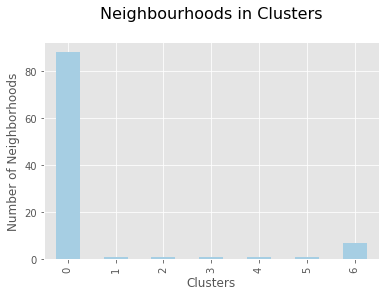

In [58]:
mycounts[['Neighbourhood']].plot(kind='bar',colormap='Paired');

plt.title('Neighbourhoods in Clusters\n', size = 16 )
plt.ylabel('Number of Neighborhoods')
plt.gca().get_legend().remove() # remove legend

plt.xlabel('Clusters')

### End
